In [1]:
import numpy as np
import pandas as pd
import pickle       # decompressing the pkl dataset
import matplotlib.pyplot as plt
import joblib

In [2]:
# Load in the DFT features
xyDFT_pkl= open('./data/BH_CR_DFT.pkl', 'rb')
xyDFT= pickle.load(xyDFT_pkl)
xsDFT=xyDFT.drop('yield', axis=1)
ysDFT=xyDFT['yield']

# Load in indices by compound number
xNum_pkl= open('./data/BH_CR_numbers.pkl', 'rb')
xNum= pickle.load(xNum_pkl)

In [3]:
from numpy.random import RandomState

def getSplit(xNum, testPct, randomSeed=None):
    '''
    Input:
    xNum: contains identities of compounds in each sample (df)
    testPct: split percentage
    randomSeed: random seed

    Output:
    idxTr: array of indices of test samples such that df.take(idxTe) returns training samples
    idxTe: array of indices of test samples such that df.take(idxTe) returns test samples
    additiveTe: additives that were split for the test set
    '''
    u= xNum.additive_number.unique()
    if randomSeed == None:
        rng= RandomState()
    else:
        rng= RandomState(randomSeed)
    additiveTe= rng.choice(u, size= int(u.size * testPct), replace=False)
    idxTe= np.array([], dtype=int)
    for add in np.nditer(additiveTe):
        addIdx= xNum.index[xNum.additive_number == add].to_numpy()
        idxTe= np.concatenate((idxTe, addIdx))
    idxTr= np.delete(np.arange(xNum.index.max()), idxTe)

    return idxTr, idxTe, additiveTe

In [4]:
# Generate splits

# Split off the test data
idxTV, idxTe, testAdditives= getSplit(xNum, testPct=0.2, randomSeed=420)
print('The test set contains additives: %s' % testAdditives)

# The test set (xTe, yTe)
xNumTe= xNum.additive_number.take(idxTe).to_numpy()
xTe= xsDFT.take(idxTe).to_numpy()
yTe= ysDFT.take(idxTe).to_numpy()

# Generate the training set
xNumTr= xNum.additive_number.take(idxTV).to_numpy()
xTr= xsDFT.take(idxTV).to_numpy()
yTr= ysDFT.take(idxTV).to_numpy()

# # Split off the validation set
# idxTr, idxVd, vdAdditives= getSplit(xNum.take(idxTV), testPct= 0.25, randomSeed=1023)
# print('The validation set contains additives: %s' % vdAdditives)

# # The validation set (xTe, yTe)
# xVd= xsDFT.take(idxVd).to_numpy()
# yVd= ysDFT.take(idxVd).to_numpy()

# # Generate the training data (xTr, yTr)
# xTr= xsDFT.take(idxTr).to_numpy()
# yTr= ysDFT.take(idxTr).to_numpy()

print('Size of the splits:')
print('Train: {}'.format(xTr.shape))
# print('Valid: {}'.format(xVd.shape))
print('Test: {}'.format(xTe.shape))

The test set contains additives: [ 5  3  9 23]
Size of the splits:
Train: (3414, 120)
Test: (720, 120)


In [5]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Linear Models

In [6]:
from sklearn.linear_model import LinearRegression

ols= LinearRegression().fit(xTr, yTr)
scaledOLS= make_pipeline(StandardScaler(), LinearRegression()).fit(xTr, yTr)

from sklearn.linear_model import RidgeCV

ridge= RidgeCV(
    alphas= np.logspace(-3,3),
    cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr),
    scoring= make_scorer(mean_squared_error, greater_is_better=False)).fit(xTr, yTr)
scaledridge= make_pipeline(StandardScaler(), RidgeCV(
    alphas= np.logspace(-3,3),
    cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr),
    scoring= make_scorer(mean_squared_error, greater_is_better=False))).fit(xTr, yTr)

from sklearn.linear_model import LassoCV

lasso= LassoCV(cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr), max_iter=10000).fit(xTr, yTr)
scaledlasso= make_pipeline(StandardScaler(), LassoCV(cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr), max_iter=10000)).fit(xTr, yTr)

from sklearn.linear_model import ElasticNetCV

enet= ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr), max_iter=10000).fit(xTr, yTr)
scaledenet= make_pipeline(StandardScaler(), ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    cv=LeaveOneGroupOut().split(xTr, yTr, groups=xNumTr), max_iter=10000)).fit(xTr, yTr)

/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.41573054203764, tolerance: 233.51446190468042
  model = cd_fast.enet_coordinate_descent_gram(
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 920.5189075412927, tolerance: 233.51446190468042
  model = cd_fast.enet_coordinate_descent_gram(
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413.2010281862458, tolerance: 233.51446190468042
  model = cd_fast.enet_coordinate_descent_gram(
/Users/nml64/.conda/envs/nmlenv/lib/pyt

The model: OLS
Training MSE: 209.27486
Test MSE: 27097189118.02183
Test RMSE: 164612.23866
Test R2: -32733729.15271
The model: scaled OLS
Training MSE: 210.29635
Test MSE: 339936144549670062915584.00000
Test RMSE: 583040431316.44824
Test R2: -410646948522119266304.00000


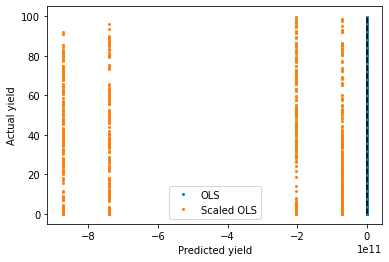

In [7]:
# Evaluate the models
# Evaluate the unscaled ols model
print('The model: OLS')
print("Training MSE: %.5f" % mean_squared_error(yTr, ols.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, ols.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, ols.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, ols.predict(xTe)))

# Evaluate the scaled ols model
print('The model: scaled OLS')
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledOLS.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledOLS.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledOLS.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledOLS.predict(xTe)))

# Generate exp-actual plot
plt.plot(ols.predict(xTe), yTe, '.', markersize=4, label='OLS')
plt.plot(scaledOLS.predict(xTe), yTe, '.', markersize=4, label='Scaled OLS')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

The model: Ridge Regression | alpha: 0.09102981779915217
Training MSE: 224.27040
Test MSE: 298.05597
Test RMSE: 17.26430
Test R2: 0.63994
The model: Scaled Ridge Regression | alpha: 244.205309454865
Training MSE: 254.24908
Test MSE: 319.31606
Test RMSE: 17.86942
Test R2: 0.61426


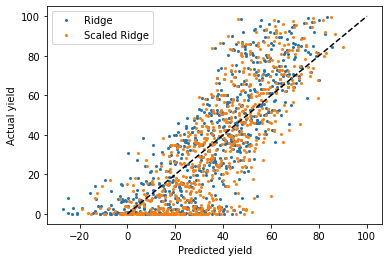

In [8]:
# Evaluate the models
# Evaluate the unscaled ridge regression model
print('The model: Ridge Regression | alpha: %s' % ridge.alpha_)
print("Training MSE: %.5f" % mean_squared_error(yTr, ridge.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, ridge.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, ridge.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, ridge.predict(xTe)))

# Evaluate the scaled ridge regression model
print('The model: Scaled Ridge Regression | alpha: %s' % scaledridge[1].alpha_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledridge.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledridge.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledridge.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledridge.predict(xTe)))

# Generate exp-actual plot
plt.plot(ridge.predict(xTe), yTe, '.', markersize=4, label='Ridge')
plt.plot(scaledridge.predict(xTe), yTe, '.', markersize=4, label='Scaled Ridge')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

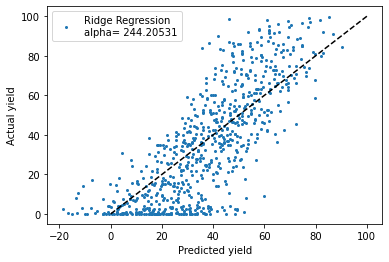

In [10]:
# Generate exp-actual plot
plt.plot(scaledridge.predict(xTe), yTe, '.', markersize=4, label='Ridge Regression\nalpha= %.5f' % scaledridge[1].alpha_)
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

The model: Lasso Regression | alpha: 39.48949
Training MSE: 353.31235
Test MSE: 377.79230
Test RMSE: 19.43688
Test R2: 0.54362
The model: Scaled Lasso Regression | alpha: 0.21558
Training MSE: 250.12168
Test MSE: 330.77352
Test RMSE: 18.18718
Test R2: 0.60042


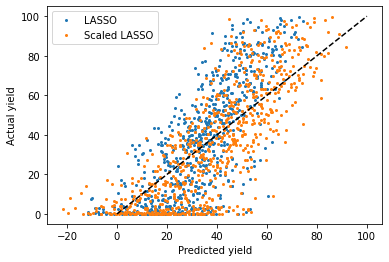

In [11]:

# Evaluate the models
# Evaluate the unscaled lasso regression model
print('The model: Lasso Regression | alpha: %.5f' % lasso.alpha_)
print("Training MSE: %.5f" % mean_squared_error(yTr, lasso.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, lasso.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, lasso.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, lasso.predict(xTe)))

# Evaluate the scaled lasso regression model
print('The model: Scaled Lasso Regression | alpha: %.5f' % scaledlasso[1].alpha_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledlasso.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledlasso.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledlasso.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledlasso.predict(xTe)))

# Generate exp-actual plot
plt.plot(lasso.predict(xTe), yTe, '.', markersize=4, label='LASSO')
plt.plot(scaledlasso.predict(xTe), yTe, '.', markersize=4, label='Scaled LASSO')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

The model: Elastic Net Regression | alpha: 39.48949 | l1 ratio: 1.00000
Training MSE: 353.31235
Test MSE: 377.79230
Test RMSE: 19.43688
Test R2: 0.54362
The model: Scaled Elastic Net Regression | alpha: 0.09332 | l1 ratio: 0.10000
Training MSE: 257.44908
Test MSE: 320.73931
Test RMSE: 17.90920
Test R2: 0.61254


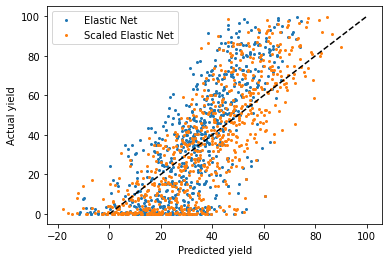

In [12]:
# Evaluate the models
# Evaluate the unscaled elastic net regression model
print('The model: Elastic Net Regression | alpha: %.5f | l1 ratio: %.5f' % (enet.alpha_, enet.l1_ratio_))
print("Training MSE: %.5f" % mean_squared_error(yTr, enet.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, enet.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, enet.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, enet.predict(xTe)))

# Evaluate the scaled elastic net regression model
print('The model: Scaled Elastic Net Regression | alpha: %.5f | l1 ratio: %.5f' % (scaledenet[1].alpha_, scaledenet[1].l1_ratio_))
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledenet.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledenet.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledenet.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledenet.predict(xTe)))

# Generate exp-actual plot
plt.plot(enet.predict(xTe), yTe, '.', markersize=4, label='Elastic Net')
plt.plot(scaledenet.predict(xTe), yTe, '.', markersize=4, label='Scaled Elastic Net')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()


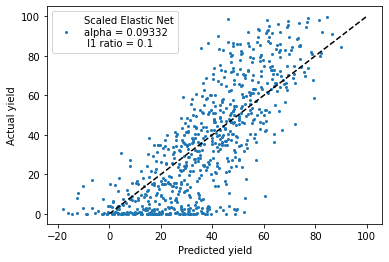

In [23]:
# Generate exp-actual plot
plt.plot(scaledenet.predict(xTe), yTe, '.', markersize=4, label='Scaled Elastic Net\nalpha = %.5f\n l1 ratio = %.1f' % (scaledenet[1].alpha_, scaledenet[1].l1_ratio_))
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

In [14]:
from sklearn.linear_model import SGDRegressor

In [16]:
sgdr= GridSearchCV(SGDRegressor(learning_rate='adaptive', early_stopping=True),
    param_grid={'alpha': np.logspace(-3,3,num=7)},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

scaledSGDR= make_pipeline(StandardScaler(),
    GridSearchCV(SGDRegressor(learning_rate='adaptive', early_stopping=True),
    param_grid={'alpha': np.logspace(-3,3, num=7), 'penalty': ['l1','l2']},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 7 candidates, totalling 133 fits
Fitting 19 folds for each of 14 candidates, totalling 266 fits


In [15]:
sgdrOPT= SGDRegressor(alpha=100.0, early_stopping=True, learning_rate='adaptive').fit(xTr, yTr)

In [17]:
scaledSGDRopt= make_pipeline(StandardScaler(), SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='adaptive')).fit(xTr, yTr)

The best model: SGDRegressor(alpha=1000.0, early_stopping=True, learning_rate='adaptive')
Training MSE: 180985313868911971277996032.00000
Test MSE: 178801775922945972062126080.00000
Test R2: -215994694445812424900608.00000
The best model: SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='adaptive')
Training MSE: 260.52111
Test MSE: 320.41064
Test RMSE: 17.90002
Test R2: 0.61294


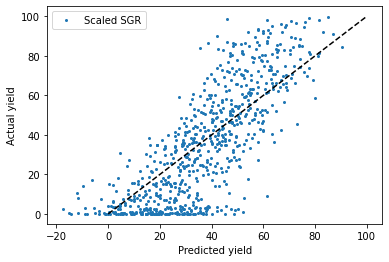

In [20]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % sgdr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, sgdr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, sgdr.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, sgdr.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledSGDR[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledSGDR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledSGDR.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledSGDR.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledSGDR.predict(xTe)))

# Generate exp-actual plot
# plt.plot(sgdr.predict(xTe), yTe, '.', markersize=4, label='KNR')
plt.plot(scaledSGDR.predict(xTe), yTe, '.', markersize=4, label='Scaled SGR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

The best model: SGDRegressor(alpha=100.0, early_stopping=True, learning_rate='adaptive')
Training MSE: 396320530059755794609471488.00000
Test MSE: 396780352233901730570436608.00000
Test R2: -479315434650920984510464.00000
The best model: SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='adaptive')
Training MSE: 260.15522
Test MSE: 322.17176
Test RMSE: 17.94914
Test R2: 0.61081


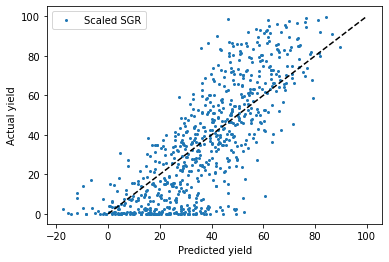

In [22]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % sgdrOPT)
print("Training MSE: %.5f" % mean_squared_error(yTr, sgdrOPT.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, sgdrOPT.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, sgdrOPT.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledSGDRopt[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledSGDRopt.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledSGDRopt.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledSGDRopt.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledSGDRopt.predict(xTe)))

# Generate exp-actual plot
plt.plot(scaledSGDRopt.predict(xTe), yTe, '.', markersize=4, label='Scaled SGR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

### Generalized Linear Models

In [78]:
from sklearn.linear_model import TweedieRegressor


In [ ]:

glm= GridSearchCV(TweedieRegressor(max_iter=1000), 
    param_grid={"power": [0, 1, 1.5, 2, 3]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

# Scale the data before fitting the data
scaledGLM= make_pipeline(StandardScaler(),
    GridSearchCV(TweedieRegressor(max_iter=1000),
    param_grid={"power": [0, 1, 1.5, 2, 3], 'alpha': np.linspace(0,1, num=6)},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

glmAMZ= make_pipeline(StandardScaler(), TweedieRegressor(power= 0, alpha= 0.1)).fit(xTr, yTr)

In [80]:
scaledGLM= make_pipeline(StandardScaler(), TweedieRegressor(power= 0, max_iter=10000, alpha= 0.2)).fit(xTr, yTr)

In [79]:

glmAMZ= make_pipeline(StandardScaler(), TweedieRegressor(power= 0, alpha= 0.1)).fit(xTr, yTr)


The best model: TweedieRegressor(alpha=0.2, max_iter=10000, power=0)
Training MSE: 276.53003
Test MSE: 332.48008
Test R2: 0.59836
The Zuranski model: TweedieRegressor(alpha=0.1, power=0)
Training MSE: 260.06268
Test MSE: 321.39541
Test RMSE: 17.92750
Test R2: 0.61175


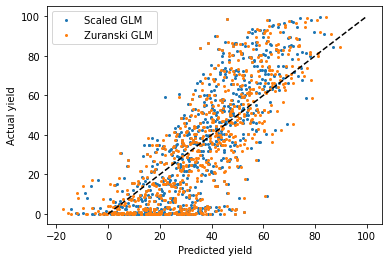

In [83]:
# Evaluate the models
# Evaluate the unscaled model
# print('The best model: %s' % glm.best_estimator_)
# print("Training MSE: %.5f" % mean_squared_error(yTr, glm.predict(xTr)))
# print("Test MSE: %.5f" % mean_squared_error(yTe, glm.predict(xTe)))
# print('Test R2: %.5f' % r2_score(yTe, glm.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledGLM[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledGLM.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledGLM.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, scaledGLM.predict(xTe)))

# Evaluate the Zuranski model
print('The Zuranski model: %s' % glmAMZ[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, glmAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, glmAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, glmAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, glmAMZ.predict(xTe)))

# Generate exp-actual plot
# plt.plot(glm.predict(xTe), yTe, '.', markersize=4, label='GLM')
plt.plot(scaledGLM.predict(xTe), yTe, '.', markersize=4, label='Scaled GLM')
plt.plot(glmAMZ.predict(xTe), yTe, '.', markersize=4, label='Zuranski GLM')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

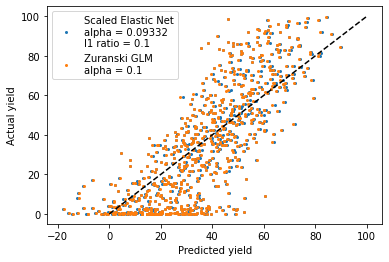

In [85]:
# Generate exp-actual plot
plt.plot(scaledenet.predict(xTe), yTe, '.', markersize=4, label='Scaled Elastic Net\nalpha = %.5f\nl1 ratio = %.1f' % (scaledenet[1].alpha_, scaledenet[1].l1_ratio_))
plt.plot(glmAMZ.predict(xTe), yTe, '.', markersize=4, label='Zuranski GLM\nalpha = 0.1')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

### k-Neighbors Regression

In [24]:
from sklearn.neighbors import KNeighborsRegressor

knr= GridSearchCV(KNeighborsRegressor(weights='distance'), 
    param_grid={"n_neighbors": [1,3,5], "p": [1,2]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

# Scale the data before fitting the data
scaledKNR= make_pipeline(StandardScaler(),
    GridSearchCV(KNeighborsRegressor(weights='distance'), 
    param_grid={"n_neighbors": [1,3,5], "p": [1,2]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 6 candidates, totalling 114 fits
Fitting 19 folds for each of 6 candidates, totalling 114 fits


In [25]:
# Scale the data before fitting the data
scaledKNR2= make_pipeline(StandardScaler(),
    GridSearchCV(KNeighborsRegressor(weights='distance'), 
    param_grid={"n_neighbors": [5, 10, 50, 100], "p": [1,2]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 8 candidates, totalling 152 fits


In [26]:
# Zuranski Model
knrAMZ=make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors= 3)).fit(xTr, yTr)

The best model: KNeighborsRegressor(n_neighbors=3, p=1, weights='distance')
Training MSE: 0.00000
Test MSE: 238.23095
Test RMSE: 15.43473
Test R2: 0.71221
The best model: KNeighborsRegressor(n_neighbors=10, p=1, weights='distance')
Training MSE: 0.00000
Test MSE: 174.05911
Test RMSE: 13.19315
Test R2: 0.78973


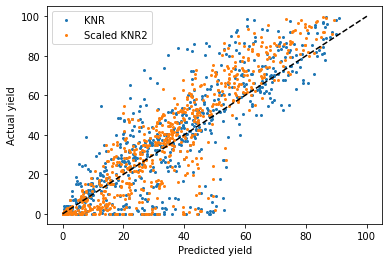

In [28]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % knr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, knr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, knr.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, knr.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, knr.predict(xTe)))

print('The best model: %s' % scaledKNR2[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledKNR2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledKNR2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledKNR2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledKNR2.predict(xTe)))

# Generate exp-actual plot
plt.plot(knr.predict(xTe), yTe, '.', markersize=4, label='KNR')
plt.plot(scaledKNR2.predict(xTe), yTe, '.', markersize=4, label='Scaled KNR2')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

The best model: KNeighborsRegressor(p=1, weights='distance')
Training MSE: 0.00000
Test MSE: 150.19646
Test RMSE: 12.25547
Test R2: 0.81856
The Zuranski model: KNeighborsRegressor(n_neighbors=3)
Training MSE: 169.40975
Test MSE: 175.38819
Test RMSE: 13.24342
Test R2: 0.78813


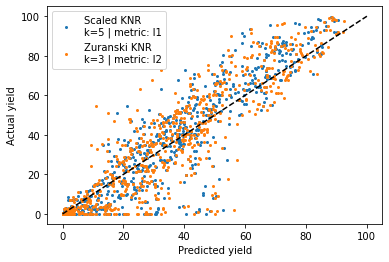

In [77]:
# Evaluate the scaled model
print('The best model: %s' % scaledKNR[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledKNR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledKNR.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledKNR.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledKNR.predict(xTe)))

# Evaluate the Zuranski model
print('The Zuranski model: %s' % knrAMZ[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, knrAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, knrAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, knrAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, knrAMZ.predict(xTe)))

# Generate exp-actual plot
plt.plot(scaledKNR.predict(xTe), yTe, '.', markersize=4, label='Scaled KNR\nk=5 | metric: l1')
plt.plot(knrAMZ.predict(xTe), yTe, '.', markersize=4, label='Zuranski KNR\nk=3 | metric: l2')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

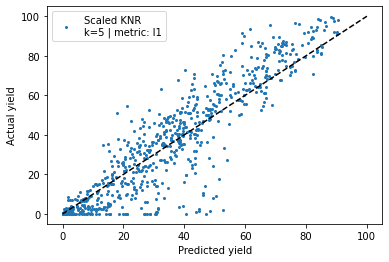

In [86]:
# Generate exp-actual plot
plt.plot(scaledKNR.predict(xTe), yTe, '.', markersize=4, label='Scaled KNR\nk=5 | metric: l1')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

In [91]:
print('All R2: %.5f' % r2_score(ysDFT.to_numpy(), scaledKNR.predict(xsDFT.to_numpy())))
print('All R2: %.5f' % r2_score(ysDFT.to_numpy(), knrAMZ.predict(xsDFT.to_numpy())))

All R2: 0.96535
All R2: 0.77448


### Gaussian Process Regression

## Something wrong here

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, DotProduct, ExpSineSquared

gp= GaussianProcessRegressor(random_state=0).fit(xTr, yTr)
gpr= GridSearchCV(gp, 
    param_grid={"kernel": [RBF, RationalQuadratic, DotProduct, ExpSineSquared]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1,
    error_score='raise').fit(xTr, yTr, groups=xNumTr)
    
scaledGPR= make_pipeline(StandardScaler(),
    GridSearchCV(GaussianProcessRegressor(), 
    param_grid={"kernel": [RBF, RationalQuadratic, DotProduct, ExpSineSquared]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

The best model: GaussianProcessRegressor(random_state=0)
Training MSE: 0.00000
Test MSE: 2086.59167
Test R2: -1.52063
The best model: GaussianProcessRegressor()
Training MSE: 0.00000
Test MSE: 1468.07639
Test R2: -0.77345


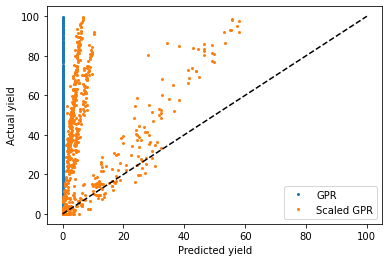

In [105]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % gp)
print("Training MSE: %.5f" % mean_squared_error(yTr, gp.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, gp.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, gp.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledGPR[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledGPR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledGPR.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, scaledGPR.predict(xTe)))

# Generate exp-actual plot
plt.plot(gpr.predict(xTe), yTe, '.', markersize=4, label='GPR')
plt.plot(scaledGPR.predict(xTe), yTe, '.', markersize=4, label='Scaled GPR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

#### Support Vector Regression

In [29]:
from sklearn.svm import SVR


In [ ]:
svr = GridSearchCV(SVR(),
    param_grid={"C": [1e-3, 1e-1, 1e0, 1e1, 1e3]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

In [30]:
svr=SVR(C=1000.0).fit(xTr, yTr)

In [114]:
scaledSVR= make_pipeline(StandardScaler(),
    GridSearchCV(SVR(),
    param_grid={"C": [1e-2, 1e0, 1e2], 'kernel': ['linear', 'rbf', 'sigmoid']},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 9 candidates, totalling 171 fits


In [31]:
scaledSVR= make_pipeline(StandardScaler(),SVR(C=100.0)).fit(xTr, yTr)

In [117]:
scaledSVR2= make_pipeline(StandardScaler(),
    GridSearchCV(SVR(),
    param_grid={"C": [10, 50, 100]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 3 candidates, totalling 57 fits


In [32]:
scaledSVR2= make_pipeline(StandardScaler(),SVR(C=10.0)).fit(xTr, yTr)

In [33]:
# Zuranski model
svrAMZ= make_pipeline(StandardScaler(),SVR(C=0.5, gamma=0.007)).fit(xTr, yTr)

The best model: SVR(C=1000.0)
Training MSE: 312.09472
Test MSE: 334.14335
Test R2: 0.59635
The best model: SVR(C=100.0)
Training MSE: 84.66643
Test MSE: 185.98374
Test RMSE: 13.63759
Test R2: 0.77533
The best model: SVR(C=10.0)
Training MSE: 183.45476
Test MSE: 231.24919
Test RMSE: 15.20688
Test R2: 0.72065
The Zuranski model: SVR(C=0.5, gamma=0.007)
Training MSE: 421.20806
Test MSE: 495.41375
Test RMSE: 22.25789
Test R2: 0.40153


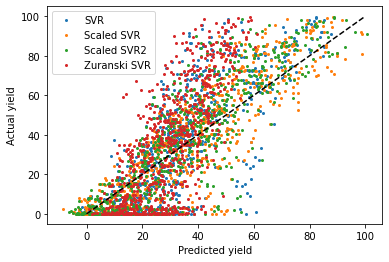

In [35]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % svr)
print("Training MSE: %.5f" % mean_squared_error(yTr, svr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, svr.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, svr.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledSVR[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledSVR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledSVR.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledSVR.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledSVR.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledSVR2[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledSVR2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledSVR2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledSVR2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledSVR2.predict(xTe)))

# Evaluate the Zuranski model
print('The Zuranski model: %s' % svrAMZ[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, svrAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, svrAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, svrAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, svrAMZ.predict(xTe)))

# Generate exp-actual plot
plt.plot(svr.predict(xTe), yTe, '.', markersize=4, label='SVR')
plt.plot(scaledSVR.predict(xTe), yTe, '.', markersize=4, label='Scaled SVR')
plt.plot(scaledSVR2.predict(xTe), yTe, '.', markersize=4, label='Scaled SVR2')
plt.plot(svrAMZ.predict(xTe), yTe, '.', markersize=4, label='Zuranski SVR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

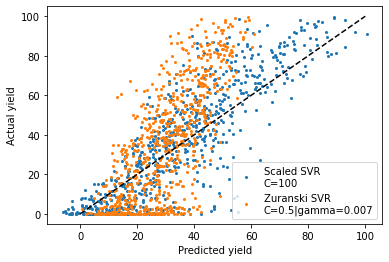

In [36]:
# Generate exp-actual plot
plt.plot(scaledSVR2.predict(xTe), yTe, '.', markersize=4, label='Scaled SVR\nC=100')
plt.plot(svrAMZ.predict(xTe), yTe, '.', markersize=4, label='Zuranski SVR\nC=0.5|gamma=0.007')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

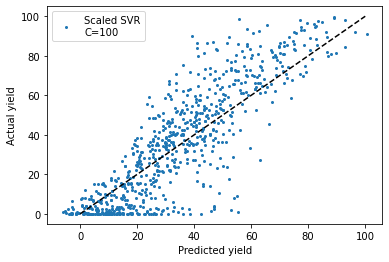

In [87]:
# Generate exp-actual plot
plt.plot(scaledSVR2.predict(xTe), yTe, '.', markersize=4, label='Scaled SVR\nC=100')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

### Tree Based Methods

#### Regression Tree

In [37]:
from sklearn.tree import DecisionTreeRegressor


In [38]:

dtr= GridSearchCV(DecisionTreeRegressor(),
    param_grid={"min_samples_leaf": [1, 10, 100, 200, 300, 400, 500]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

scaledDTR= make_pipeline(StandardScaler(), 
    GridSearchCV(DecisionTreeRegressor(),
    param_grid={"min_samples_leaf": [1, 10, 100, 200, 300, 400, 500]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)


Fitting 19 folds for each of 7 candidates, totalling 133 fits
Fitting 19 folds for each of 7 candidates, totalling 133 fits


The best model: DecisionTreeRegressor(min_samples_leaf=300)
Training MSE: 360.47375
Test MSE: 588.46026
Test R2: 0.28913
The best model: DecisionTreeRegressor(min_samples_leaf=300)
Training MSE: 360.47375
Test MSE: 588.46026
Test RMSE: 24.25820
Test R2: 0.28913


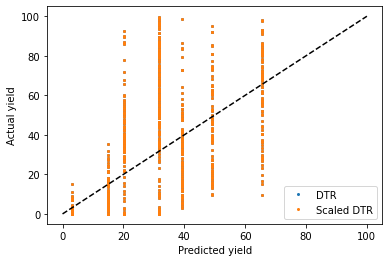

In [39]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % dtr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, dtr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, dtr.predict(xTe)))
print('Test R2: %.5f' % r2_score(yTe, dtr.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledDTR[1].best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledDTR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledDTR.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledDTR.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledDTR.predict(xTe)))

# Generate exp-actual plot
plt.plot(dtr.predict(xTe), yTe, '.', markersize=4, label='DTR')
plt.plot(scaledDTR.predict(xTe), yTe, '.', markersize=4, label='Scaled DTR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()


In [41]:
from sklearn.ensemble import RandomForestRegressor


In [ ]:

rfr= GridSearchCV(RandomForestRegressor(max_features='sqrt'),
    param_grid={"n_estimators": [10, 100, 300, 500]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)


In [43]:
rfr= RandomForestRegressor(n_estimators=300).fit(xTr, yTr)

In [141]:
scaledRFR= make_pipeline(StandardScaler(), 
    GridSearchCV(RandomForestRegressor(max_features='sqrt'),
    param_grid={"n_estimators": [10, 100, 300, 500]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)


Fitting 19 folds for each of 4 candidates, totalling 76 fits


In [50]:
scaledRFR= make_pipeline(StandardScaler(), RandomForestRegressor(max_features='sqrt', n_estimators=300)).fit(xTr, yTr)


In [206]:
scaledRFR2= make_pipeline(StandardScaler(), 
    GridSearchCV(RandomForestRegressor(max_features='sqrt'),
    param_grid={"n_estimators": [10, 20, 30, 40, 50]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 5 candidates, totalling 95 fits


In [52]:
scaledRFR2= make_pipeline(StandardScaler(), RandomForestRegressor(max_features='log2', n_estimators=300)).fit(xTr, yTr)

In [46]:
# Zuranski Model
rfrAMZ= make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=20)).fit(xTr, yTr)

The best model: RandomForestRegressor(n_estimators=300)
Training MSE: 6.72118
Test MSE: 367.71620
Test RMSE: 19.17593
Test R2: 0.55579
The best model: RandomForestRegressor(max_features='sqrt', n_estimators=300)
Training MSE: 7.78959
Test MSE: 174.49538
Test RMSE: 13.20967
Test R2: 0.78921
The best model: RandomForestRegressor(max_features='log2', n_estimators=300)
Training MSE: 10.53292
Test MSE: 173.58045
Test RMSE: 13.17499
Test R2: 0.79031
The Zuranski model: RandomForestRegressor(n_estimators=20)
Training MSE: 8.63755
Test MSE: 372.43733
Test RMSE: 19.29864
Test R2: 0.55009


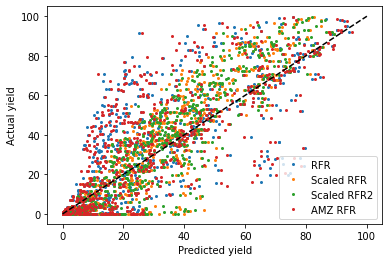

In [53]:
# Evaluate the models
# Evaluate the unscaled model
print('The best model: %s' % rfr)
print("Training MSE: %.5f" % mean_squared_error(yTr, rfr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, rfr.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, rfr.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, rfr.predict(xTe)))

# Evaluate the scaled model
print('The best model: %s' % scaledRFR[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledRFR.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledRFR.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledRFR.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledRFR.predict(xTe)))

# Evaluate the scaled model2
print('The best model: %s' % scaledRFR2[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledRFR2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledRFR2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledRFR2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledRFR2.predict(xTe)))

# Evaluate the Zuranski model
print('The Zuranski model: %s' % rfrAMZ[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, rfrAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, rfrAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, rfrAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, rfrAMZ.predict(xTe)))

# Generate exp-actual plot
plt.plot(rfr.predict(xTe), yTe, '.', markersize=4, label='RFR')
plt.plot(scaledRFR.predict(xTe), yTe, '.', markersize=4, label='Scaled RFR')
plt.plot(scaledRFR2.predict(xTe), yTe, '.', markersize=4, label='Scaled RFR2')
plt.plot(rfrAMZ.predict(xTe), yTe, '.', markersize=4, label='AMZ RFR')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

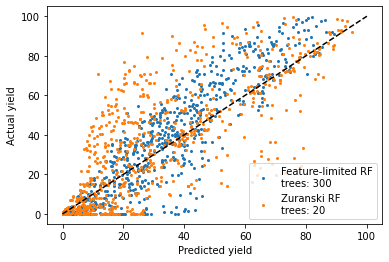

In [60]:
# Generate exp-actual plot
plt.plot(scaledRFR2.predict(xTe), yTe, '.', markersize=4, label='Feature-limited RF\ntrees: 300')
plt.plot(rfrAMZ.predict(xTe), yTe, '.', markersize=4, label='Zuranski RF\ntrees: 20')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

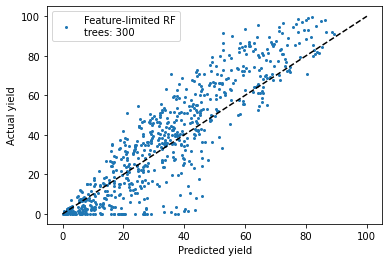

In [88]:
# Generate exp-actual plot
plt.plot(scaledRFR2.predict(xTe), yTe, '.', markersize=4, label='Feature-limited RF\ntrees: 300')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

In [147]:
from sklearn.ensemble import GradientBoostingRegressor

gbr= GridSearchCV(GradientBoostingRegressor(),
    param_grid={"n_estimators": [100], 'learning_rate': np.logspace(-2,2, num=5)},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 5 candidates, totalling 95 fits


/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_

In [149]:
gbr2= GridSearchCV(GradientBoostingRegressor(),
    param_grid={"n_estimators": [100, 200, 500, 700]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 4 candidates, totalling 76 fits


The best model: GradientBoostingRegressor()
Training MSE: 99.10524
Test MSE: 262.52054
Test RMSE: 16.20249
Test R2: 0.68287
The best model: GradientBoostingRegressor(n_estimators=200)
Training MSE: 77.51768
Test MSE: 259.66457
Test RMSE: 16.11411
Test R2: 0.68632


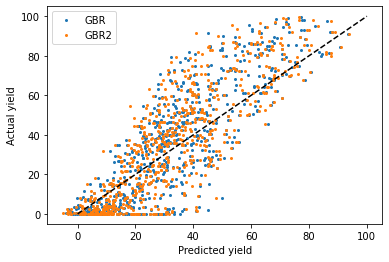

In [150]:
# Evaluate the model
print('The best model: %s' % gbr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, gbr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, gbr.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, gbr.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, gbr.predict(xTe)))

# Evaluate the model
print('The best model: %s' % gbr2.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, gbr2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, gbr2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, gbr2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, gbr2.predict(xTe)))

# Generate exp-actual plot
plt.plot(gbr.predict(xTe), yTe, '.', markersize=4, label='GBR')
plt.plot(gbr2.predict(xTe), yTe, '.', markersize=4, label='GBR2')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

In [151]:
from sklearn.ensemble import AdaBoostRegressor

abr= GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), loss='exponential'),
    param_grid={"n_estimators": [10, 50, 100], 'learning_rate': [0.1, 1, 10]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 9 candidates, totalling 171 fits


The best model: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.1, loss='exponential', n_estimators=100)
Training MSE: 241.67828
Test MSE: 353.44687
Test RMSE: 18.80018
Test R2: 0.57303


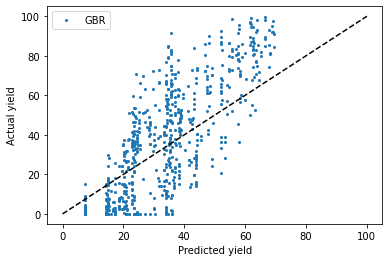

In [152]:
abr= gbr2
# Evaluate the model
print('The best model: %s' % abr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, abr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, abr.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, abr.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, abr.predict(xTe)))

# Generate exp-actual plot
plt.plot(abr.predict(xTe), yTe, '.', markersize=4, label='GBR')
# plt.plot(gbr2.predict(xTe), yTe, '.', markersize=4, label='GBR2')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

In [178]:
import xgboost as xgb

xgr= GridSearchCV(xgb.XGBRegressor(eval_metric= mean_squared_error),
    param_grid={"n_estimators": [20, 30, 40], 'max_depth': [3,6,9]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)


Fitting 19 folds for each of 9 candidates, totalling 171 fits


In [198]:
es= xgb.callback.EarlyStopping(
    rounds=10,
    save_best=True,
    maximize=False,
)
xgr2= xgb.XGBRegressor(max_depth=3, n_estimators= 30, learning_rate=0.3).fit(xTr, yTr, eval_set=[(xTe, yTe)], callbacks=[es])

[0]	validation_0-rmse:36.34080
[1]	validation_0-rmse:31.33442
[2]	validation_0-rmse:27.18060
[3]	validation_0-rmse:24.67166
[4]	validation_0-rmse:22.87093
[5]	validation_0-rmse:21.37030
[6]	validation_0-rmse:19.93080
[7]	validation_0-rmse:19.37893
[8]	validation_0-rmse:18.63076
[9]	validation_0-rmse:18.33080
[10]	validation_0-rmse:18.13804
[11]	validation_0-rmse:17.99882
[12]	validation_0-rmse:17.71888
[13]	validation_0-rmse:17.57911
[14]	validation_0-rmse:17.52519
[15]	validation_0-rmse:17.60779
[16]	validation_0-rmse:17.54482
[17]	validation_0-rmse:17.53032
[18]	validation_0-rmse:17.40806
[19]	validation_0-rmse:17.39369
[20]	validation_0-rmse:17.44930
[21]	validation_0-rmse:17.33359
[22]	validation_0-rmse:17.32383
[23]	validation_0-rmse:17.27554
[24]	validation_0-rmse:17.16879
[25]	validation_0-rmse:17.16968
[26]	validation_0-rmse:17.19999
[27]	validation_0-rmse:17.14594
[28]	validation_0-rmse:17.22299
[29]	validation_0-rmse:17.19072


In [167]:
xgr3= GridSearchCV(xgb.XGBRegressor(max_depth=3, n_estimators= 30),
    param_grid={"learning_rate": [.1, .3, .5, 1.0], "n_estimators": [20, 30, 40], 'max_depth': [3, 6, 9]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 36 candidates, totalling 684 fits


In [220]:
xgr4= GridSearchCV(xgb.XGBRegressor(max_depth=3, n_estimators= 30, learning_rate=0.3),
    param_grid={'subsample': [0.2, 0.4, 0.6, 0.8, 1]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 5 candidates, totalling 95 fits


In [218]:
# Zuranski Model
xgrAMZ= xgb.XGBRegressor(max_depth=6, n_estimators= 15, learning_rate= 0.3, gamma=0, subsample=1).fit(xTr, yTr)

The best model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x7fb9edbb1790>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=30, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Training MSE: 103.14910
Test MSE: 295.52073
Test RMSE: 17.19072
Test R2: 0.64301
The best model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, impor

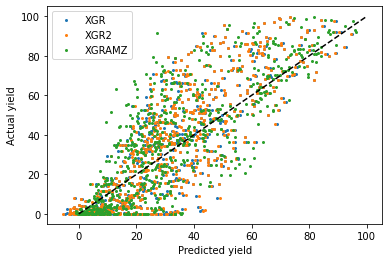

In [221]:
# Evaluate the model
print('The best model: %s' % xgr.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, xgr.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, xgr.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, xgr.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, xgr.predict(xTe)))

# Evaluate the model
print('The best model: %s' % xgr2)
print("Training MSE: %.5f" % mean_squared_error(yTr, xgr2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, xgr2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, xgr2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, xgr2.predict(xTe)))

# Evaluate the model
print('The best model: %s' % xgr4.best_estimator_)
print("Training MSE: %.5f" % mean_squared_error(yTr, xgr4.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, xgr4.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, xgr4.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, xgr4.predict(xTe)))

# Evaluate the model
print('The Zuranski model: %s' % xgrAMZ)
print("Training MSE: %.5f" % mean_squared_error(yTr, xgrAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, xgrAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, xgrAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, xgrAMZ.predict(xTe)))

# Generate exp-actual plot
plt.plot(xgr.predict(xTe), yTe, '.', markersize=4, label='XGR')
plt.plot(xgr2.predict(xTe), yTe, '.', markersize=4, label='XGR2')
# plt.plot(xgr3.predict(xTe), yTe, '.', markersize=4, label='XGR3')
plt.plot(xgrAMZ.predict(xTe), yTe, '.', markersize=4, label='XGRAMZ')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

### Neural Nets

In [233]:
from sklearn.neural_network import MLPRegressor

nnr= GridSearchCV(MLPRegressor(),
    param_grid={"hidden_layer_sizes": [(1), (5,), (10,), (100,)], "alpha": [1e-5, 1e-4, 1e-3]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1).fit(xTr, yTr, groups=xNumTr)

Fitting 19 folds for each of 10 candidates, totalling 190 fits


/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

In [245]:
scaledNNR= make_pipeline(StandardScaler(),
    GridSearchCV(MLPRegressor(),
    param_grid={"hidden_layer_sizes": [(3,), (4,), (5,), (6,), (8,), (10,)]},
    cv=LeaveOneGroupOut(),
    scoring= make_scorer(mean_squared_error, greater_is_better=False),
    verbose= 1)).fit(xTr, yTr, gridsearchcv__groups=xNumTr)

Fitting 19 folds for each of 6 candidates, totalling 114 fits


/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/nml64/.conda/envs/nmlenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

In [68]:
from sklearn.neural_network import MLPRegressor
scaledNNR2= make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(6,), max_iter=10000)).fit(xTr, yTr)

In [70]:
scaledNNR2= make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(6,), max_iter=10000)).fit(xTr, yTr)

In [64]:
nnrAMZ= make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(4,), max_iter=10000)).fit(xTr, yTr)

The best model: MLPRegressor(hidden_layer_sizes=(6,), max_iter=10000)
Training MSE: 144.94959
Test MSE: 231.67839
Test RMSE: 15.22099
Test R2: 0.72013
The Zuranski model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(4,), max_iter=10000))])
Training MSE: 156.74751
Test MSE: 280.71653
Test RMSE: 16.75460
Test R2: 0.66089


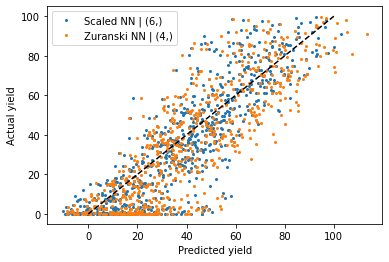

In [73]:
# Evaluate the model
# print('The best model: %s' % nnr.best_estimator_)
# print("Training MSE: %.5f" % mean_squared_error(yTr, nnr.predict(xTr)))
# print("Test MSE: %.5f" % mean_squared_error(yTe, nnr.predict(xTe)))
# print("Test RMSE: %.5f" % mean_squared_error(yTe, nnr.predict(xTe), squared=False))
# print('Test R2: %.5f' % r2_score(yTe, nnr.predict(xTe)))

# # Evaluate the model
# print('The best model: %s' % scaledNNR[1].best_estimator_)
# print("Training MSE: %.5f" % mean_squared_error(yTr, scaledNNR.predict(xTr)))
# print("Test MSE: %.5f" % mean_squared_error(yTe, scaledNNR.predict(xTe)))
# print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledNNR.predict(xTe), squared=False))
# print('Test R2: %.5f' % r2_score(yTe, scaledNNR.predict(xTe)))

# Evaluate the model
print('The best model: %s' % scaledNNR2[1])
print("Training MSE: %.5f" % mean_squared_error(yTr, scaledNNR2.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, scaledNNR2.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, scaledNNR2.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, scaledNNR2.predict(xTe)))

# Evaluate the model
print('The Zuranski model: %s' % nnrAMZ)
print("Training MSE: %.5f" % mean_squared_error(yTr, nnrAMZ.predict(xTr)))
print("Test MSE: %.5f" % mean_squared_error(yTe, nnrAMZ.predict(xTe)))
print("Test RMSE: %.5f" % mean_squared_error(yTe, nnrAMZ.predict(xTe), squared=False))
print('Test R2: %.5f' % r2_score(yTe, nnrAMZ.predict(xTe)))

# Generate exp-actual plot
# plt.plot(nnr.predict(xTe), yTe, '.', markersize=4, label='NNR')
# plt.plot(scaledNNR.predict(xTe), yTe, '.', markersize=4, label='Scaled NNR')
plt.plot(scaledNNR2.predict(xTe), yTe, '.', markersize=4, label='Scaled NN | (6,)')
plt.plot(nnrAMZ.predict(xTe), yTe, '.', markersize=4, label='Zuranski NN | (4,)')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()

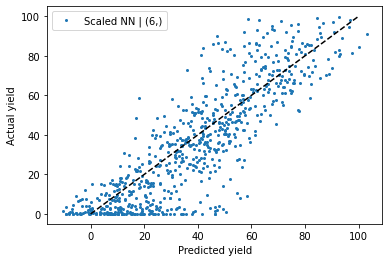

In [89]:
# Generate exp-actual plot
plt.plot(scaledNNR2.predict(xTe), yTe, '.', markersize=4, label='Scaled NN | (6,)')
plt.plot(np.linspace(0,100),np.linspace(0,100), 'k--')
plt.ylabel('Actual yield')
plt.xlabel('Predicted yield')
plt.legend()
plt.show()